In [3]:
from google.colab import drive
drive.mount('/content/drive')
caminho_drive = '/content/drive/My Drive/colab/snake/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install keras-rl2

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import math
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import StandardScaler

import gym
from gym import spaces

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.constraints import max_norm

from rl.agents.dqn import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import GreedyQPolicy, EpsGreedyQPolicy, LinearAnnealedPolicy
from keras.callbacks.callbacks import LambdaCallback
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [0]:
def cria_modelo(n_acoes, input_shape, porc_dropout):

    rna = models.Sequential()
    rna.add(layers.Flatten(input_shape=input_shape))

    rna.add(layers.Dense(256,activation='relu', kernel_constraint=max_norm(3)))
    rna.add(layers.Dropout(porc_dropout))

    rna.add(layers.Dense(128,activation='relu', kernel_constraint=max_norm(3)))
    rna.add(layers.Dropout(porc_dropout))

    rna.add(layers.Dense(64,activation='relu', kernel_constraint=max_norm(3)))
    rna.add(layers.Dropout(porc_dropout))

    rna.add(layers.Dense(32,activation='relu', kernel_constraint=max_norm(3)))
    rna.add(layers.Dropout(porc_dropout))

    rna.add(layers.Dense(n_acoes, activation='softmax'))

    #rna.compile(optimizer='sgd', loss='mse')
    #rna.compile(optimizer='sgd', loss='mse', metrics=['accuracy'])

    return rna

In [0]:
class SnakeEnv(gym.Env):
    def __init__(self, janela_aprendizado):
        self.n_acoes = 4
        self.action_space = spaces.Discrete(self.n_acoes)
        self.observation_space = spaces.Box( low=-1 , high=1 , shape=(janela_aprendizado,) + (15, 15) )
        self.campo = None
        self.qnt_linhas = None
        self.qnt_colunas = None
        self.posicoes_cobra = None
        self.desconto_por_casa = -0.001
        self.reset()

    def observacao(self):
        obs = []
        for i in range( len(self.campo[0]) ):
            obs.append( self.campo[0][i] )
        return obs

    def step(self, acao):
        
        recompensa = None
        acabou = False
        regret = 0

        posicao_cabeca_x = self.posicoes_cobra[0][0]
        posicao_cabeca_y = self.posicoes_cobra[0][1]
        
        if acao == 0: #cima
            posicao_cabeca_y += -1
        elif acao == 1: #direita
            posicao_cabeca_x += 1
        elif acao == 2: #baixo
            posicao_cabeca_y += 1
        elif acao == 3: #esquerda
            posicao_cabeca_x += -1

        recompensa = self.campo[0][ posicao_cabeca_y ][ posicao_cabeca_x ]

        if recompensa == -1:
            acabou = True
        else:
            self.posicoes_cobra.insert(0, [ posicao_cabeca_x, posicao_cabeca_y ])
            self.campo[0][posicao_cabeca_y][posicao_cabeca_x] = 0

            if recompensa == 1:
                self.gera_maca()
                self.campo[0][ self.posicoes_cobra[1][1] ][ self.posicoes_cobra[1][0] ] = -1
            else:
                self.campo[0][ self.posicoes_cobra[-1][1] ][ self.posicoes_cobra[-1][0] ] = self.desconto_por_casa
                self.posicoes_cobra.pop()
                self.campo[0][ self.posicoes_cobra[-1][1] ][ self.posicoes_cobra[-1][0] ] = -1

        return self.observacao(), recompensa, acabou, {'regret':regret}

    def gera_maca(self):
        linha = 0
        coluna = 0
        while self.campo[0][linha][coluna] == -1:
            linha = np.random.choice( self.qnt_linhas )
            coluna = np.random.choice( self.qnt_colunas )
        self.campo[0][linha][coluna] = 1

    def reset(self):
        #self.campo = np.full( self.observation_space.shape, self.desconto_por_casa )
        self.campo = np.zeros( self.observation_space.shape )
        self.qnt_linhas = len(self.campo[0][0])
        self.qnt_colunas = len(self.campo[0])
        self.campo[0][0] = -1
        self.campo[0][-1] = -1
        for i in range(len(self.campo[0])):
            self.campo[0][i][0] = -1
            self.campo[0][i][-1] = -1
        self.posicoes_cobra = []
        self.posicoes_cobra.append( [int(self.qnt_linhas / 2), int(self.qnt_colunas / 2)] )
        self.posicoes_cobra.append( [self.posicoes_cobra[0][0], self.posicoes_cobra[0][1] + 1] )
        self.campo[0][ self.posicoes_cobra[0][1] ][ self.posicoes_cobra[0][0] ] = 0
        self.campo[0][ self.posicoes_cobra[-1][1] ][ self.posicoes_cobra[-1][0] ] = -1
        self.gera_maca()
        return self.observacao()

    def render(self, mode='human'):
        pass

In [128]:
np.random.seed(10)

janela_aprendizado = 1 #quantas linhas da memoria vai pegar pra treinar o modelo por vez
ambiente = SnakeEnv( janela_aprendizado ) #cria o ambiente para o jogo
n_acoes = ambiente.n_acoes #define o numero de saidas da rede
input_shape = ambiente.observation_space.shape

memoria = SequentialMemory(limit=50000, window_length=janela_aprendizado)
modelo = cria_modelo( n_acoes, input_shape, 0.2 )
metricas = ['accuracy']

n_steps_1 = 200000
n_steps_2 = 200000
n_steps_aquecimento = 100
n_steps_1_por_1000 = int(n_steps_1 / 1000)
n_steps_2_por_1000 = int(n_steps_2 / 1000)

n_max_steps_por_episodio = 1000

agora = str( datetime.now() - timedelta(hours = 3) ).replace(' ', '_') #horario de brasilia UTC-3
caminho_export = '{0}{1}_{2}k_{3}k_steps_'.format( caminho_drive, agora, n_steps_1_por_1000, n_steps_2_por_1000 )

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [129]:
eps_max = 1
eps_min = 0
politica = LinearAnnealedPolicy( inner_policy=EpsGreedyQPolicy(), attr='eps', value_max=eps_max, value_min=eps_min, nb_steps=n_steps_1, value_test=0 ) #0.2 antes do decay
agente = DQNAgent( model=modelo, policy=politica, nb_actions=n_acoes, memory=memoria, enable_double_dqn=True, test_policy=GreedyQPolicy(), nb_steps_warmup=n_steps_aquecimento )
agente.compile(optimizers.Adam(), metrics=metricas)

resultados_treino = []
intervalo_log_1 = int( n_steps_1 / 5 )
intervalo_modelo_1 = int( n_steps_1 / 5 )
callbacks_treino_1 = []
callbacks_treino_1.append( FileLogger( 'log_1.log' ) )
callbacks_treino_1.append( FileLogger( '{0}log_1.log'.format( caminho_export ) ) )
callbacks_treino_1.append( LambdaCallback( on_batch_end=lambda batch,logs: resultados_treino.append( logs ) ) )
callbacks_treino_1.append( ModelIntervalCheckpoint( '{0}dqn_1.h5f'.format( caminho_export ) , interval=intervalo_modelo_1 ) )
historia_treino = agente.fit(env=ambiente, nb_steps=n_steps_1, visualize=False, verbose=1, callbacks=callbacks_treino_1, log_interval=intervalo_log_1, nb_max_episode_steps=n_max_steps_por_episodio)
#historia_treino = agente.fit(env=ambiente, nb_steps=n_steps_1, visualize=False, verbose=0, callbacks=callbacks_treino_1)

agente.save_weights('dqn_1.h5f', overwrite=True)
agente.save_weights( '{0}dqn_1.h5f'.format( caminho_export ), overwrite=True )

Training for 200000 steps ...
Interval 1 (0 steps performed)
40000/40000 [==============================] - 542s 14ms/step - reward: -0.2157
8784 episodes - episode_reward: -0.982 [-1.008, 0.999] - loss: 0.162 - accuracy: 0.375 - mean_q: 0.418 - mean_eps: 0.900 - regret: 0.000

Interval 2 (40000 steps performed)
40000/40000 [==============================] - 542s 14ms/step - reward: -0.1846
7576 episodes - episode_reward: -0.974 [-1.011, 1.000] - loss: 0.152 - accuracy: 0.437 - mean_q: 0.382 - mean_eps: 0.700 - regret: 0.000

Interval 3 (80000 steps performed)
40000/40000 [==============================] - 530s 13ms/step - reward: -0.1593
6531 episodes - episode_reward: -0.975 [-1.011, 1.000] - loss: 0.128 - accuracy: 0.492 - mean_q: 0.352 - mean_eps: 0.500 - regret: 0.000

Interval 4 (120000 steps performed)
40000/40000 [==============================] - 532s 13ms/step - reward: -0.1321
5499 episodes - episode_reward: -0.961 [-1.010, 1.999] - loss: 0.111 - accuracy: 0.435 - mean_q: 0.

In [131]:
agente = DQNAgent( model=modelo, policy=EpsGreedyQPolicy( 0.2 ), nb_actions=n_acoes, memory=memoria )
agente.compile(optimizers.Adam(), metrics=metricas)
agente.load_weights('dqn_1.h5f')

intervalo_log_2 = int( n_steps_2 / 5 )
intervalo_modelo_2 = int( n_steps_2 / 5 )
callbacks_treino_2 = []
callbacks_treino_2.append( FileLogger( 'log_2.log' ) )
callbacks_treino_2.append( FileLogger( '{0}log_2.log'.format( caminho_export ) ) )
callbacks_treino_2.append( LambdaCallback( on_batch_end=lambda batch,logs: resultados_treino.append( logs ) ) )
callbacks_treino_2.append( ModelIntervalCheckpoint( '{0}dqn_2.h5f'.format( caminho_export ) , interval=intervalo_modelo_2 ) )
historia_treino_2 = agente.fit(env=ambiente, nb_steps=n_steps_2, visualize=False, verbose=1, callbacks=callbacks_treino_2, log_interval=intervalo_log_2, nb_max_episode_steps=n_max_steps_por_episodio)
#historia_treino_2 = agente.fit(env=ambiente, nb_steps=n_steps_teste, visualize=False, verbose=0, callbacks=callbacks_treino_2)

agente.save_weights('dqn_2.h5f', overwrite=True)
agente.save_weights( '{0}dqn_2.h5f'.format( caminho_export ) , overwrite=True )

Training for 200000 steps ...
Interval 1 (0 steps performed)
40000/40000 [==============================] - 485s 12ms/step - reward: -0.1179
4948 episodes - episode_reward: -0.954 [-1.015, 1.000] - loss: 0.082 - accuracy: 0.432 - mean_q: 0.320 - regret: 0.000

Interval 2 (40000 steps performed)
39082/40000 [============================>.] - ETA: 11s - reward: -0.1246done, took 970.878 seconds


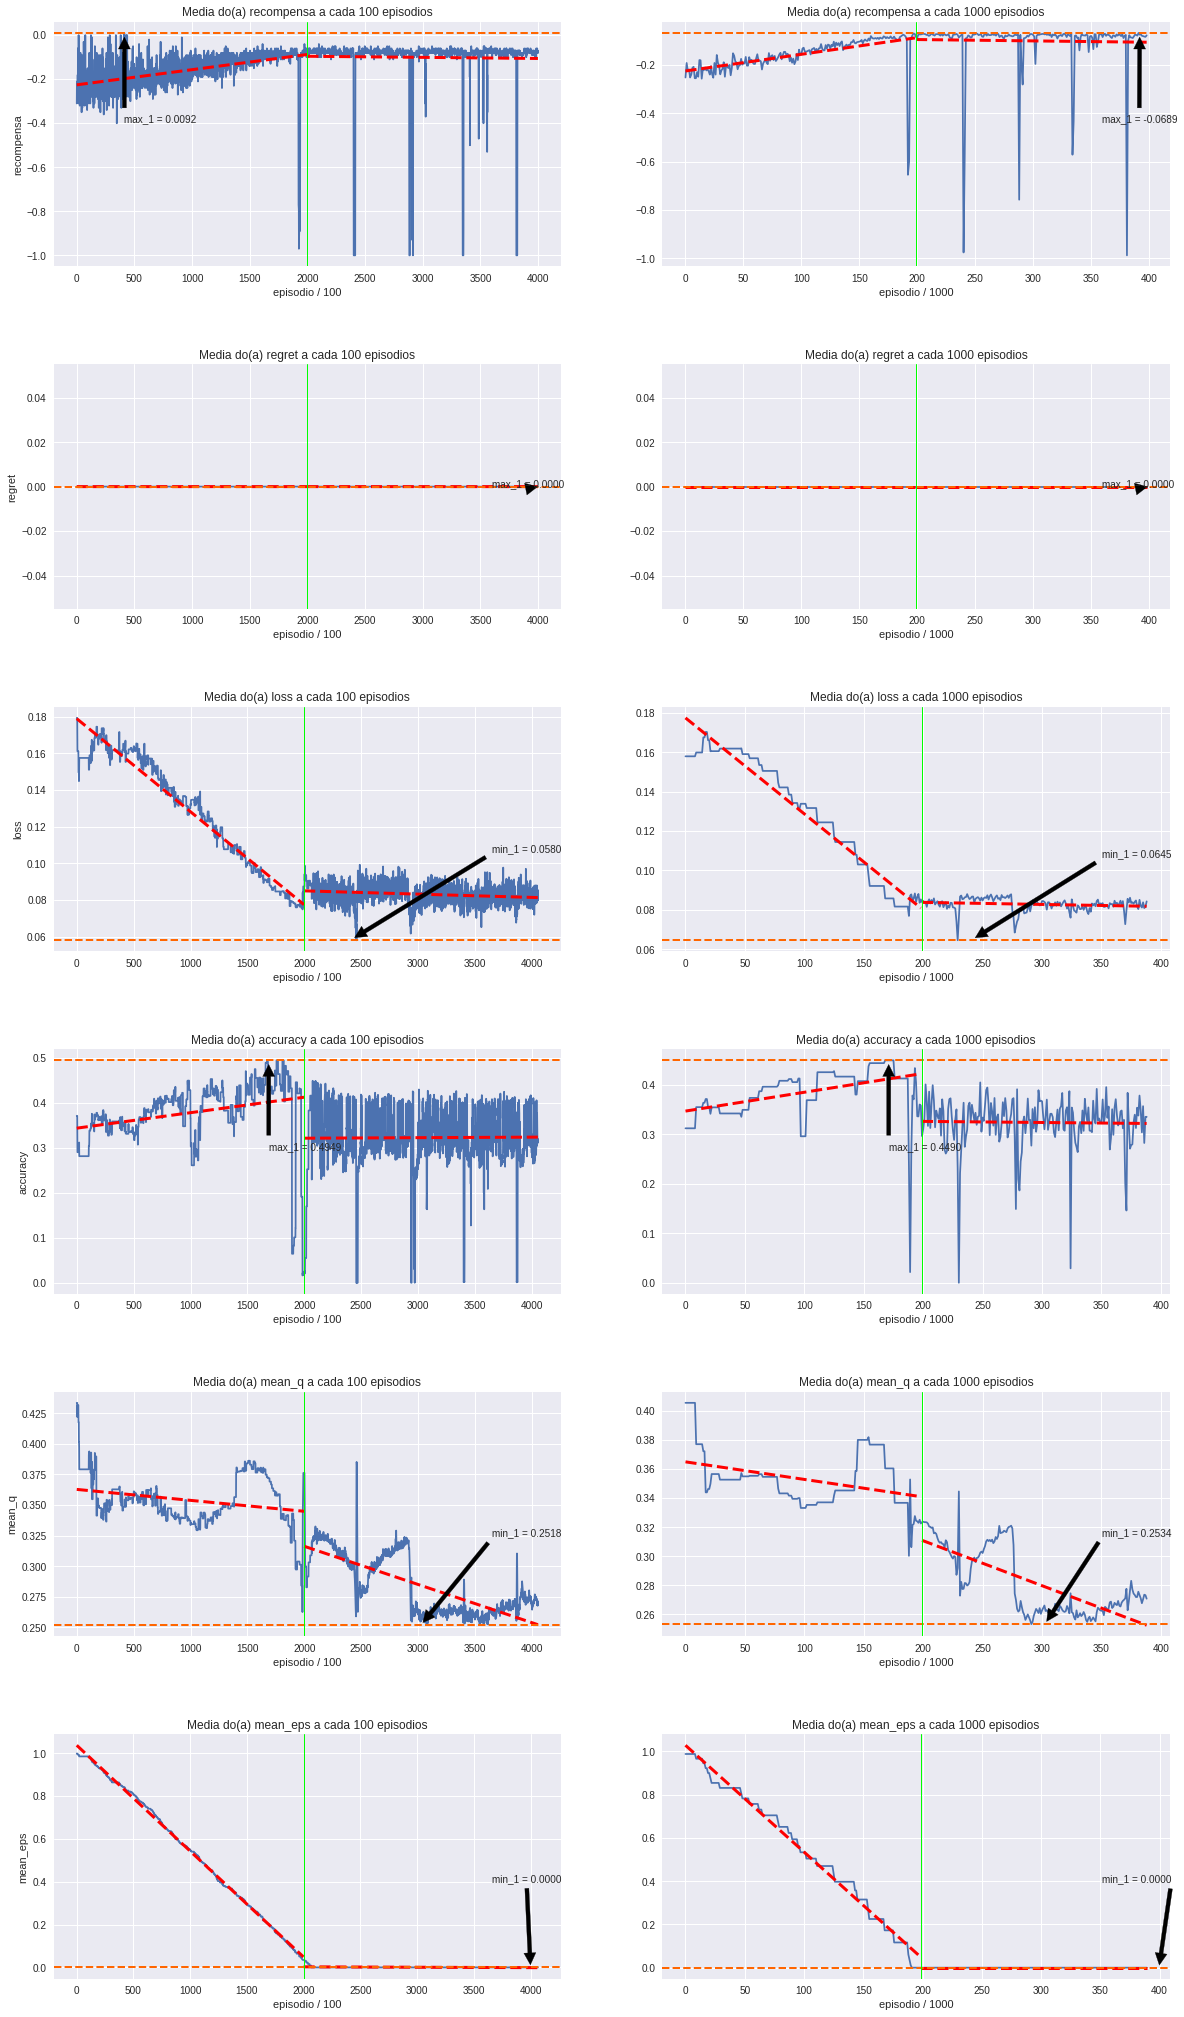

In [107]:
plt.style.use('seaborn')
#nm_metricas = ['recompensa', 'regret', 'loss', 'accuracy', 'mean_q', 'mean_eps']
nm_metricas = ['recompensa', 'regret', 'loss', 'accuracy', 'mean_q', 'mean_eps']
metrica_max = [True, True, False, True, False, False]
divisores = [100, 1000] #quantidade de episodios a dividir a media
result = resultados_treino
n_resultados = len(result)
tipo = 'treino_full'
pular_n_steps = n_steps_aquecimento
fig_size_x = 20
fig_size_y = len(nm_metricas) * 6

fig, axs = plt.subplots(len(nm_metricas), len(divisores), gridspec_kw={'hspace': 0.4, 'wspace': 0.2}, figsize=( fig_size_x , fig_size_y ))
#fig.suptitle('Medias por episodios do {}'.format(tipo))
for metrica_i in range(len(nm_metricas)):

    nm_metrica = nm_metricas[metrica_i]
    if len(divisores) == 1:
        axs[metrica_i].set(ylabel=nm_metrica)
    else:
        axs[metrica_i][0].set(ylabel=nm_metrica)
    grafico = 0

    for divisor in divisores:

        axes = None
        if len(divisores) == 1:
            axes = axs[metrica_i]
        else:
            axes = axs[metrica_i][grafico]
        grafico = 0
        axes.set(title='Media do(a) {} a cada {} episodios'.format(nm_metrica, divisor))

        hist_metricas = []
        metricas_media = []
        metricas_ref = []
        ref = result[pular_n_steps]['episode']

        # [ posicao em x do maior ponto na media , posicao y do maior ponto na media , maior ponto ]
        max_metrica_media_1 = [None, None]
        min_metrica_media_1 = [None, None]

        for i in range(0, n_resultados + 1):
            if len(hist_metricas) % divisor == 0 and len(hist_metricas) > 0:
                metricas_media.append( sum(hist_metricas[-divisor:]) / divisor )
                #pega maximos e minimos
                if max_metrica_media_1[1] == None or metricas_media[-1] >= max_metrica_media_1[1]:
                    max_metrica_media_1[0] = i / divisor
                    max_metrica_media_1[1] = metricas_media[-1]
                if min_metrica_media_1[1] == None or metricas_media[-1] <= min_metrica_media_1[1]:
                    min_metrica_media_1[0] = i / divisor
                    min_metrica_media_1[1] = metricas_media[-1]
            if (i == n_resultados or result[i]['episode'] != ref) and len(metricas_ref) > 0:
                hist_metricas.append( sum(metricas_ref) / len(metricas_ref) )
                ref += 1
                metricas_ref = []
            if i < n_resultados:
                if metrica_i == 0: #recompensa
                    metricas_ref.append( result[i]['reward'] )
                elif metrica_i == 1: #regret
                    metricas_ref.append( result[i]['info']['regret'] )
                else: #outras metricas
                    if metrica_i - 2 == len(result[i]['metrics']): #se for o epsilon
                        metricas_ref.append( 0 )
                    else:
                        if not math.isnan( result[i]['metrics'][metrica_i-2] ): #tem que ser diferente de Not a Number (NaN)
                            metricas_ref.append( result[i]['metrics'][metrica_i-2] )

        n_steps_media_treino_1 = int((n_steps_1 - pular_n_steps) / divisor)
        n_steps_media_total = len(metricas_media)
        #plota grafico
        x_plot = np.arange(n_steps_media_total)
        axes.set(xlabel='episodio / {}'.format(divisor))
        axes.plot(x_plot, metricas_media)
        #linha de tendencia antes do epsilon = 0
        z = np.polyfit(x_plot[:n_steps_media_treino_1], metricas_media[:n_steps_media_treino_1], 1)
        p = np.poly1d(z)
        axes.plot(x_plot[:n_steps_media_treino_1], p(x_plot[:n_steps_media_treino_1]), c='#ff0000', ls="--", linewidth=3, label='tendencia eps decay')
        #linha de tendencia antes do epsilon = 0
        z = np.polyfit(x_plot[n_steps_media_treino_1:], metricas_media[n_steps_media_treino_1:], 1)
        p = np.poly1d(z)
        axes.plot(x_plot[n_steps_media_treino_1:], p(x_plot[n_steps_media_treino_1:]), c='#ff0000', ls="--", linewidth=3, label='tendencia eps = 0')
        #maximo e minimo
        if metrica_max[metrica_i]:
            #linha de maximo_1
            anotacao_x_max = max_metrica_media_1[0]
            if max_metrica_media_1[0] > n_steps_media_total / 2:
                anotacao_x_max = n_steps_media_total * 0.9
            anotacao_y_max = ((max_metrica_media_1[1] - min_metrica_media_1[1]) * 0.6) + min_metrica_media_1[1]
            axes.axhline(max_metrica_media_1[1], c='#ff6600', ls='--', linewidth=2, label='maximo_1')
            axes.annotate( 'max_1 = {:.4f}'.format(max_metrica_media_1[1]), 
                                            xy=( max_metrica_media_1[0] , max_metrica_media_1[1] ),
                                            xytext=( anotacao_x_max , anotacao_y_max ),
                                            arrowprops=dict(facecolor='black', shrink=0.05) )
        else:
            #linha de minimo_1
            anotacao_x_min = min_metrica_media_1[0]
            if min_metrica_media_1[0] > n_steps_media_total / 2:
                anotacao_x_min = n_steps_media_total * 0.9
            anotacao_y_min = ((max_metrica_media_1[1] - min_metrica_media_1[1]) * 0.4) + min_metrica_media_1[1]
            axes.axhline(min_metrica_media_1[1], c='#ff6600', ls='--', linewidth=2, label='minimo_1')
            axes.annotate( 'min_1 = {:.4f}'.format(min_metrica_media_1[1]),
                                            xy=( min_metrica_media_1[0] , min_metrica_media_1[1] ),
                                            xytext=( anotacao_x_min , anotacao_y_min ),
                                            arrowprops=dict(facecolor='black', shrink=0.03) )
        #linha do epsilon = 0
        axes.axvline( x=n_steps_media_treino_1, c='#00ff00' , linewidth=1, label='epsilon = 0')
        
        grafico += 1

fig.show()
fig.savefig('result_{}.png'.format(tipo), bbox_inches='tight') #salva o grafico em uma foto
fig.savefig('{0}result_{1}.png'.format( caminho_export, tipo ), bbox_inches='tight') #salva o grafico em uma foto

In [132]:
ambiente = SnakeEnv( 1 ) #cria o ambiente para o jogo

agente = DQNAgent( model=modelo, policy=GreedyQPolicy(), nb_actions=n_acoes, memory=memoria )
agente.compile(optimizers.Adam(), metrics=metricas)
agente.load_weights('dqn_2.h5f')

resultados_teste = []
callbacks_teste = []
callbacks_teste.append( LambdaCallback( on_batch_end=lambda batch,logs: resultados_teste.append( logs ) ) )
agente.test(ambiente, nb_episodes=10, verbose=1, visualize=False, callbacks=callbacks_teste)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Testing for 10 episodes ...
Episode 1: reward: -1.000, steps: 2
Episode 2: reward: -1.000, steps: 2
Episode 3: reward: -1.000, steps: 2
Episode 4: reward: -1.000, steps: 2
Episode 5: reward: -1.000, steps: 2
Episode 6: reward: -1.000, steps: 2
Episode 7: reward: -1.000, steps: 2
Episode 8: reward: -1.000, steps: 2
Episode 9: reward: -1.000, steps: 2
Episode 10: reward: -1.000, steps: 2


In [0]:
def pinta_mais( x, y, tamanho, data, cor ):
    for i in range(tamanho):
        for j in range(tamanho):
            data[tamanho * x + i][tamanho * y + j] = cor

import cv2

# initialize water image
tamanho = 20
tamanho_x = ambiente.observation_space.shape[1] * tamanho
tamanho_y = ambiente.observation_space.shape[2] * tamanho
water_depth = np.zeros((tamanho_y, tamanho_x), dtype=float)
video = []

# initialize video writer
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
fps = 10
video_filename = '{0}test.mp4'.format( caminho_export )
out = cv2.VideoWriter(video_filename, fourcc, fps, (tamanho_x, tamanho_y))

for log in resultados_teste:
    data = np.zeros( (tamanho_x, tamanho_y, 3), dtype=np.uint8 )
    for i in range(int(tamanho_x / tamanho)):
        for j in range(int(tamanho_y / tamanho)):
            if log['observation'][j][i] == 1:
                pinta_mais(i, j, tamanho, data, [0,0,255] )
            elif i == 0 or j == 0 or i == int(tamanho_x / tamanho) or j == int(tamanho_y / tamanho):
                pinta_mais(i, j, tamanho, data, [0,0,0] )
            elif log['observation'][j][i] == ambiente.desconto_por_casa:
                pinta_mais(i, j, tamanho, data, [255,255,255] )
            else:
                pinta_mais(i, j, tamanho, data, [0,255,0] )
            
    video.append(data)
    out.write(data)

# close out the video writer
out.release()